# The Lamb Lies Down on Broadway's Project
Fernando Sckaff, Catherine Lawrence, Samitha Kosanam

In [1]:
# OBS: You must have CUDA in your machine. 
# Otherwise, some of the code must be changed (delete all .cuda() calls).

# --------------- Import Libraries --------------- #
import matplotlib.pyplot as plt  # Plot
from numpy import linalg as LA   # Get L-2 Norm
from utils import mnist_reader   # Get Iris Dataset
import numpy as np               # Data preprocessing
            
# Import necessary PyTorch    
import torch
import torch.nn as nn
from torchsummary import summary # Summarize model
from torch.nn.functional import normalize

# Reproducibility
torch.manual_seed(0)
np.random.seed(0)

# Use CUDA if possible
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device", device)

# --------------- Import Data --------------- #
# Fetch Iris Dataset
X_train, y_train = mnist_reader.load_mnist('data/fashion', kind='train')
X_test, y_test = mnist_reader.load_mnist('data/fashion', kind='t10k')

# Correct datatype
X_train = np.float32(X_train)
X_test = np.float32(X_test)

# Normalize train dataset
train_dataset = torch.from_numpy(X_train)
train_dataset_norm = (train_dataset-torch.mean(train_dataset))/torch.std(train_dataset)

# Normalize test dataset
test_dataset = torch.from_numpy(X_test)
test_dataset_norm = (test_dataset-torch.mean(test_dataset))/torch.std(test_dataset)

# Image sample we will be using
j = 2

# Helper function to shuffle data
def shuffle_data(data):
    size = data.shape[0]
    index = torch.randperm(size)
    new_data = data[index]
    return new_data

Device cuda:0


# Model + Training

**Question 1:** The best non-convolutional (only fully connected layer) autoencoder you can obtain clearly detailing the architecture, learning rules, loss functions (and include the settings of all free parameters). Detailed explanation on the report.

In [2]:
class Autoencoder(nn.Module):
    def __init__(self, input_dim = 784, latent = 8):
        super().__init__()
        
        # Encoder block
        self.encoder = nn.Sequential(
            # First linear layer. Takes features and shrinks it in half
            nn.Linear(in_features=input_dim, out_features=input_dim//2),
            # First activation function. LeakyReLU with a negative slope of 0.5.
            nn.LeakyReLU(0.5),
            
            # Second linear layer, takes the halved input and shrinks in half once again
            nn.Linear(in_features=input_dim//2, out_features=input_dim//4),
            # Same Activation function.
            nn.LeakyReLU(0.5),
            
            # Third linear layer, shrinks it into the latent space
            nn.Linear(in_features=input_dim//4, out_features=latent),
            # Last activation function of the encoder, latent layer is given.
            nn.LeakyReLU(0.5))
        
        # Decoder block
        self.decoder = nn.Sequential(
            # Latent space is now being decoded to 1/4 of the original size
            nn.Linear(in_features=latent, out_features=input_dim//4),
            # LeakyReLU activation function with a negative slope of 0.5 once again.
            nn.LeakyReLU(0.5),
            
            # Second-to-last fully connected layer, broadening the features to double its size
            nn.Linear(in_features=input_dim//4, out_features=input_dim//2),
            nn.LeakyReLU(0.5),
            
            # Last FC layer. Image should be decoded by now
            nn.Linear(in_features=input_dim//2, out_features=input_dim))

    # Forward function
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# Loss = Mean-Squared-Error. A linear loss function
criterion = nn.MSELoss()
    
# Model summary
summary(Autoencoder().to(device), (32, 784))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1              [-1, 32, 392]         307,720
         LeakyReLU-2              [-1, 32, 392]               0
            Linear-3              [-1, 32, 196]          77,028
         LeakyReLU-4              [-1, 32, 196]               0
            Linear-5                [-1, 32, 8]           1,576
         LeakyReLU-6                [-1, 32, 8]               0
            Linear-7              [-1, 32, 196]           1,764
         LeakyReLU-8              [-1, 32, 196]               0
            Linear-9              [-1, 32, 392]          77,224
        LeakyReLU-10              [-1, 32, 392]               0
           Linear-11              [-1, 32, 784]         308,112
Total params: 773,424
Trainable params: 773,424
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.10
Forward/

## Training function

In [3]:
def training(model, dataset, optimizer, criterion, latent_dim, epochs, output=True, batch_size = 1000):

    # Initialize data and loss
    train_loss = []
    best_loss = 100
    dataset = shuffle_data(dataset)

    data_size  = dataset.shape[0]
    batches = data_size//batch_size

    # Train model
    for epoch in range(epochs):
        running_loss = 0.0

        for i in range(batches):
            # Update batch
            start = i*batch_size
            end = min(data_size, start+batch_size)
            data = dataset[start:end]   

            # Train
            optimizer.zero_grad()
            outputs = model(data.cuda())
            loss = criterion(outputs, data.cuda())
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        loss = running_loss / batches

        train_loss.append(loss)
        
        if(output):
            # Output the loss every 20 epochs
            if epoch % 20 == 0:
                print('Epoch {} of {}, Train Loss: {:.6f}'.format(epoch+1, epochs, running_loss))

            # If we have a better loss after 20 epochs, update it
            if (loss < best_loss) and (epoch % 20 == 0):
                best_loss = loss
                print('best loss: ', best_loss)
                
                with torch.no_grad():
                    model.eval()
                    
                    temp_result = model(test_dataset_norm.cuda())
                    best_loss = criterion(temp_result, test_dataset_norm.cuda())
    
    # Output best loss
    if(output):
        print('FINAL BEST LOSS: ', best_loss)

# Project Tasks

## Task 1: Latent Space Calculation

**Question 2:** In the decoder of the autoencoder, given the output of the AE, determine:
- The input of each layer using least-squares. 
- Compute the difference using a reasonable norm between the latent space discovered by the AE and by your least-squares approach. 
- Do this for both the training and test sets provided by fashionMNIST.

In [4]:
# Initialize model
num_epochs = 300
task1_model = Autoencoder().to(device)
optimizer = torch.optim.Adam(task1_model.parameters(), lr=0.001)

# Train the model. Make output = True if you want to see it learning.
training(model=task1_model, dataset=train_dataset_norm, optimizer=optimizer, 
         criterion=criterion, latent_dim=16, output=False, epochs=num_epochs)

### Predict latent space from output
Since $y=Wx+b$, then $$x=W^+(y-b)$$

#### Train Dataset

In [5]:
with torch.no_grad():
    task1_model.eval()
    
    # Get the weights and biases of the decoder layers
    W4, b4 = task1_model.decoder[0].weight, task1_model.decoder[0].bias
    W5, b5 = task1_model.decoder[2].weight, task1_model.decoder[2].bias
    W6, b6 = task1_model.decoder[4].weight, task1_model.decoder[4].bias

    # [TRAIN] Output of the AE
    y_pred = task1_model(train_dataset_norm.cuda())   
    
    # Compute the best input for decoder-fc3 (L6) using least-squares
    L6_input = torch.matmul(torch.pinverse(W6), (y_pred - b6).t())
    
    # Run backwards ReLU. Negative slope = 0.5
    L6_input = torch.where(L6_input >= 0, L6_input, L6_input/0.5)
    
    # Compute the best input for decoder-fc2 (L5) using least-squares
    L5_input = torch.matmul(torch.pinverse(W5), (L6_input - b5.unsqueeze(1)))

    # Run backwards ReLU. Negative slope = 0.5
    L5_input = torch.where(L5_input >= 0, L5_input, L5_input/0.5)
    
    # Compute the best input for decoder-fc1 (L4 - latent space) using least-squares
    L4_input = torch.matmul(torch.pinverse(W4), (L5_input - b4.unsqueeze(1)))
    
    # Compute the difference between the latent spaces using L2 norm
    latent_space = task1_model.encoder(train_dataset_norm.cuda())
    
    # NORMALIZATION: Frobenius norm
    difference = torch.norm(latent_space - L4_input.t())
    print("[TRAIN] Difference between the latent spaces:", difference.item())

[TRAIN] Difference between the latent spaces: 0.012473972514271736


#### Test Dataset

In [6]:
with torch.no_grad():
    task1_model.eval()
    
    # Get the weights and biases of the decoder layers
    W4, b4 = task1_model.decoder[0].weight, task1_model.decoder[0].bias
    W5, b5 = task1_model.decoder[2].weight, task1_model.decoder[2].bias
    W6, b6 = task1_model.decoder[4].weight, task1_model.decoder[4].bias

    # [TEST] Output of the AE
    y_pred = task1_model(test_dataset_norm.cuda())   
    
    # Compute the best input for decoder-fc3 (L6) using least-squares
    L6_input = torch.matmul(torch.pinverse(W6), (y_pred - b6).t())
    
    # Run backwards ReLU. Negative slope = 0.5
    L6_input = torch.where(L6_input >= 0, L6_input, L6_input/0.5)
    
    # Compute the best input for decoder-fc2 (L5) using least-squares
    L5_input = torch.matmul(torch.pinverse(W5), (L6_input - b5.unsqueeze(1)))

    # Run backwards ReLU. Negative slope = 0.5
    L5_input = torch.where(L5_input >= 0, L5_input, L5_input/0.5)
    
    # Compute the best input for decoder-fc1 (L4 - latent space) using least-squares
    L4_input = torch.matmul(torch.pinverse(W4), (L5_input - b4.unsqueeze(1)))
    
    # Compute the difference between the latent spaces using L2 norm
    latent_space = task1_model.encoder(test_dataset_norm.cuda())
    
    # NORMALIZATION: Frobenius norm
    difference = torch.norm(latent_space - L4_input.t())
    print("[TEST] Difference between the latent spaces:", difference.item())

[TEST] Difference between the latent spaces: 0.0050775278359651566


**Observation:** It seems the model works better with the *Test* dataset instead of the *Train* dataset. We re-ran this quite a few times. We don't know why the latent space works better with the *Test* dataset.

## Task 2: Latent Space Reconstruction
**Question 3:** In the decoder of the autoencoder, given the target of the AE (a training set instance), determine:
- The input of each layer using least-squares. For example, if you have 3 fc layers in the decoder, you need to begin with the output obtained from the AE and then obtain the best input to decoder-fc3, decoder-fc2 and decoder-fc1 (which is the latent space) using least-squares. 
- Compute the difference using a reasonable norm between the latent space discovered by the AE and by your least-squares approach.
- Find the output of the AE decoder using your discovered latent space. Document the errors at the top layer between your outputs and the targets using a reasonable norm. Do this for both the training and test sets.

In [7]:
# Initialize model
num_epochs = 300
task2_model = Autoencoder().to(device)
optimizer = torch.optim.Adam(task2_model.parameters(), lr=0.001)

# Train. Make output = True if you want to see it learning.
training(model=task2_model, dataset=train_dataset_norm, optimizer=optimizer, 
         criterion=criterion, latent_dim=16, output=False, epochs=num_epochs)

### Predict latent space from output
Since $y=Wx+b$, then $$x=W^+(y-b)$$

#### Train

[TRAIN] Difference between the latent spaces: 1.8420825654175133e-05


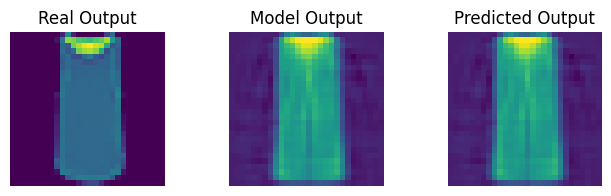

In [8]:
with torch.no_grad():
    task2_model.eval()
    
    # Get the weights and biases of the decoder layers
    W4, b4 = task2_model.decoder[0].weight, task2_model.decoder[0].bias
    W5, b5 = task2_model.decoder[2].weight, task2_model.decoder[2].bias
    W6, b6 = task2_model.decoder[4].weight, task2_model.decoder[4].bias

    # [TRAIN] Output of the AE
    y_pred = task2_model(train_dataset_norm[j].cuda())   
    
    # Compute the best input for decoder-fc3 (L6) using least-squares
    L6_input = torch.matmul(torch.pinverse(W6), (y_pred - b6))
    
    # Run backwards ReLU. Negative slope = 0.5
    L6_input = torch.where(L6_input >= 0, L6_input, L6_input/0.5)
    
    # Compute the best input for decoder-fc2 (L5) using least-squares
    L5_input = torch.matmul(torch.pinverse(W5), (L6_input - b5))
    
    # Run backwards ReLU. Negative slope = 0.5
    L5_input = torch.where(L5_input >= 0, L5_input, L5_input/0.5)
    
    # Compute the best input for decoder-fc1 (L4 - latent space) using least-squares
    L4_input = torch.matmul(torch.pinverse(W4), (L5_input - b4))
    
    # Compute the difference between the latent spaces using L2 norm
    latent_space = task2_model.encoder(train_dataset_norm[j].cuda())
    
    # NORMALIZATION: L2-Norm
    difference = torch.norm(latent_space - L4_input, p=2)
    print("[TRAIN] Difference between the latent spaces:", difference.item())
    
    # True model decoder
    output_true = y_pred.reshape([28, 28]).cpu().detach().numpy()

    # Predicted model decoder
    output_pred = task2_model.decoder(L4_input)
    output_pred = output_pred.reshape([28, 28]).cpu().detach().numpy()
    
# Compare
f, axarr = plt.subplots(1, 3, figsize=(8, 2))
axarr[0].imshow(train_dataset_norm[j].reshape([28,28]))
axarr[0].title.set_text('Real Output')
axarr[0].axis('off')

axarr[1].imshow(output_true)
axarr[1].title.set_text('Model Output')
axarr[1].axis('off')

axarr[2].imshow(output_pred)
axarr[2].title.set_text('Predicted Output')
axarr[2].axis('off')
plt.show()

#### Test

[TEST] Difference between the latent spaces: 4.1358529415447265e-05


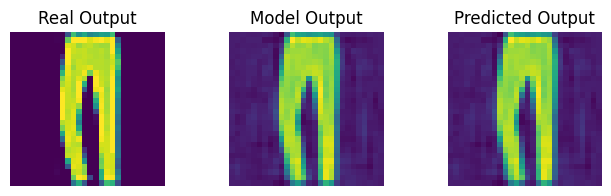

In [9]:
with torch.no_grad():
    task2_model.eval()
    
    # Get the weights and biases of the decoder layers
    W4, b4 = task2_model.decoder[0].weight, task2_model.decoder[0].bias
    W5, b5 = task2_model.decoder[2].weight, task2_model.decoder[2].bias
    W6, b6 = task2_model.decoder[4].weight, task2_model.decoder[4].bias

    # [TEST] Output of the AE
    y_pred = task2_model(test_dataset_norm[j].cuda())   
    
    # Compute the best input for decoder-fc3 (L6) using least-squares
    L6_input = torch.matmul(torch.pinverse(W6), (y_pred - b6))
    
    # Run backwards ReLU. Negative slope = 0.5
    L6_input = torch.where(L6_input >= 0, L6_input, L6_input/0.5)
    
    # Compute the best input for decoder-fc2 (L5) using least-squares
    L5_input = torch.matmul(torch.pinverse(W5), (L6_input - b5))
    
    # Run backwards ReLU. Negative slope = 0.5
    L5_input = torch.where(L5_input >= 0, L5_input, L5_input/0.5)
    
    # Compute the best input for decoder-fc1 (L4 - latent space) using least-squares
    L4_input = torch.matmul(torch.pinverse(W4), (L5_input - b4))
    
    # Compute the difference between the latent spaces using L2 norm
    latent_space = task2_model.encoder(test_dataset_norm[j].cuda())
    
    # NORMALIZATION: L2-Norm
    difference = torch.norm(latent_space - L4_input, p=2)
    print("[TEST] Difference between the latent spaces:", difference.item())
    
    # True model decoder
    output_true = y_pred.reshape([28, 28]).cpu().detach().numpy()

    # Predicted model decoder
    output_pred = task2_model.decoder(L4_input)
    output_pred = output_pred.reshape([28, 28]).cpu().detach().numpy()
    
# Compare
f, axarr = plt.subplots(1, 3, figsize=(8, 2))
axarr[0].imshow(test_dataset_norm[j].reshape([28,28]))
axarr[0].title.set_text('Real Output')
axarr[0].axis('off')

axarr[1].imshow(output_true)
axarr[1].title.set_text('Model Output')
axarr[1].axis('off')

axarr[2].imshow(output_pred)
axarr[2].title.set_text('Predicted Output')
axarr[2].axis('off')
plt.show()

## Task 3: Comparing Losses (NRMSE) vs. Compression Ratio
**Question 4:** For both the AE and your latent space discovered in (3) above, compute the compression ratios for a range of latent space cardinalities. Do this for both the training and test sets provided by fashionMNIST. MSELoss will require normalization, NRMSE.

NRMSE being $$NRMSE = \frac{RMSE}{y_{max} - y_{min}}$$
and RMSE being:
$$RMSE = \sqrt{\frac{1}{n}\sum_{i=1}^{n}\|y_i - \hat{y}_i\|^2_2}$$

### Calculate Loss Function

In [10]:
# An array for all the final Train Loss (NRMSE) for each CR
nrmse_train = []

# An array for all the final Test Loss (NRMSE) for each CR
nrmse_test = []

# Training the model and calculating the NRMSE for each CR
def calculate_loss(latent_dim):
    # Loss Function: MSELoss
    criterion = nn.MSELoss()
    
    # Model
    model = Autoencoder().to(device)
    
    # Optimizer: Adam (SGD + Momentum)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    
    # Number of epochs
    num_epochs = 160
    
    # Train the model
    training(model=model, dataset=train_dataset_norm, optimizer=optimizer, criterion=criterion, 
             latent_dim=latent_dim, epochs=num_epochs, output=False, batch_size=1000)
    
    # Evaluate Train and Test 
    with torch.no_grad():
        model.eval()
        
        result_train = model(train_dataset_norm.cuda()).detach().cpu().numpy()
        result_test = model(test_dataset_norm.cuda()).detach().cpu().numpy()

    ### Calculate Train NRMSE ###
    train_rmse = 0

    for i in range(train_dataset_norm.shape[0]):
        # Calculating the square root of the norm of the difference. Using L2-Norm
        train_rmse += np.linalg.norm(train_dataset_norm[i].cpu().detach().numpy()-result_train[i], ord=2)

    # Dividing the result by the number of samples, taking the square root, and normalizing
    train_nrmse = np.sqrt(train_rmse/result_train.shape[0])/(train_dataset_norm.max().item() - train_dataset_norm.min().item())
    
    ### Calculate Test NRMSE ###
    test_rmse = 0

    for i in range(test_dataset_norm.shape[0]):
        # Calculating the square root of the norm of the difference. Using L2-Norm
        test_rmse += np.linalg.norm(test_dataset_norm[i].cpu().detach().numpy()-result_test[i], ord=2)

    # Dividing the result by the number of samples, taking the square root, and normalizing
    test_nrmse = np.sqrt(test_rmse/result_test.shape[0])/(test_dataset_norm.max().item() - test_dataset_norm.min().item())

    # Append both results on array for diplay later on
    nrmse_train.append(train_nrmse)
    nrmse_test.append(test_nrmse)
    return model

### Train different Compression Ratios

In [12]:
# 4-latent-space
model_4  = calculate_loss(4)

# 8-latent-space
model_8  = calculate_loss(8)

# 16-latent-space
model_16  = calculate_loss(16)

# 112-latent-space
model_112  = calculate_loss(112)

# 784-latent-space
model_784  = calculate_loss(784)

### Visualize reconstructions (for utility purposes)

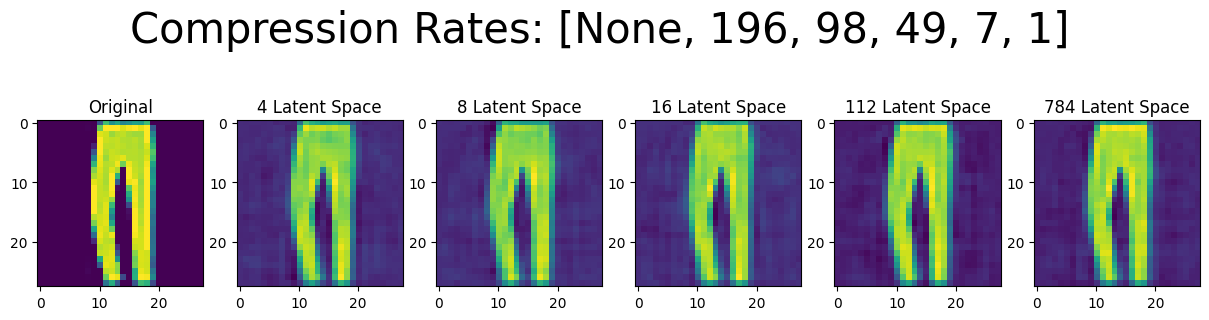

In [13]:
y_pred_4 = model_4(test_dataset_norm[j].cuda()).reshape([28,28])
y_pred_8 = model_8(test_dataset_norm[j].cuda()).reshape([28,28])
y_pred_16 = model_16(test_dataset_norm[j].cuda()).reshape([28,28])
y_pred_112 = model_112(test_dataset_norm[j].cuda()).reshape([28,28])
y_pred_784 = model_784(test_dataset_norm[j].cuda()).reshape([28,28])

f, axarr = plt.subplots(1, 6, figsize=(15, 4))
axarr[0].imshow(test_dataset_norm[j].reshape([28, 28]))
axarr[0].title.set_text('Original')

axarr[1].imshow(y_pred_4.cpu().detach().numpy())
axarr[1].title.set_text('4 Latent Space')

axarr[2].imshow(y_pred_8.cpu().detach().numpy())
axarr[2].title.set_text('8 Latent Space')

axarr[3].imshow(y_pred_16.cpu().detach().numpy())
axarr[3].title.set_text('16 Latent Space')

axarr[4].imshow(y_pred_112.cpu().detach().numpy())
axarr[4].title.set_text('112 Latent Space')

axarr[5].imshow(y_pred_784.cpu().detach().numpy())
axarr[5].title.set_text('784 Latent Space')

f.suptitle('Compression Rates: [None, 196, 98, 49, 7, 1]', size=30)
plt.show()

### Visualize NRMSE vs. CR

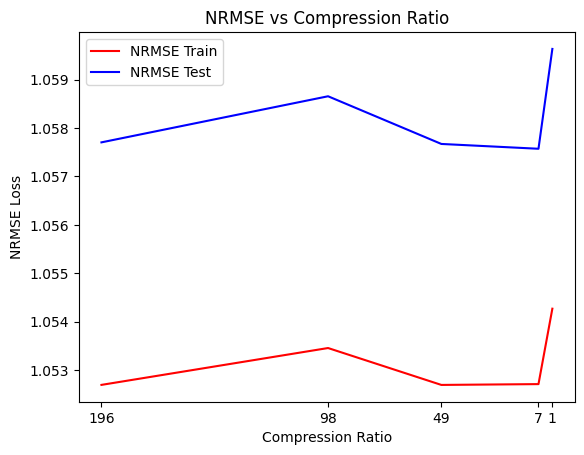

In [15]:
latent_spaces = [4, 8, 16, 112, 784]
compression_ratio = [784/4, 784/8, 784/16, 784/112, 784/784]

# NRMSE
plt.plot(compression_ratio, nrmse_train, c='r', label='NRMSE Train')
plt.plot(compression_ratio, nrmse_test, c='b', label='NRMSE Test')

plt.title('NRMSE vs Compression Ratio')
plt.xlabel('Compression Ratio')
plt.xticks(compression_ratio)
plt.ylabel('NRMSE Loss')
plt.legend(loc="best")
plt.gca().invert_xaxis()
plt.show()